In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon, ttest_rel
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from multiprocessing.dummy import Pool as ThreadPool

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('poster',font_scale=1)

In [3]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model
    

    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model
    
    auroc_all = []
    tpr_all = []
    fpr_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
#         #Round predicted scores for Regression to nearest whole number
#         if (model_name == 'Random Forest Regressor'):
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        yscore = clf.predict_proba(Xte)
        if len(np.unique(yte))>1:
            yte_bin = label_binarize(yte, clf.classes_)
            for c in list(range(yte_bin.shape[1]))[::-1]:
                if not any(yte_bin[:,c]):
                    yte_bin = np.delete(yte_bin,[c],axis=1)
                    yscore = np.delete(yscore,[c],axis=1)
                
            auroc = roc_auc_score(yte_bin,yscore,average='weighted')
            fpr_mean = np.array(range(0,101))/100
            tprs = []
            for i in range(yte_bin.shape[1]):
                yt = yte_bin[:,i]
                ys = yscore[:,i]
                fpr, tpr, thresh = roc_curve(yt,ys)
                tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                tprs.append(tpr)
                
            tpr = sum(tprs)
            fpr = fpr_mean
        else:
            #print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
            fpr = np.array([])
            tpr = np.array([])

        tpr_all.append(tpr)
        fpr_all.append(fpr)
        auroc_all.append(auroc)
        
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
    
    groupres[model_name] = {'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all}
    
    return results, groupres

In [4]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [5]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

In [6]:
floatMax = np.finfo(np.float32).max
datadict = {'watch':{},'sensor':{}, 'accel':{}}
for freq in [50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['watch'][freq] = data[data.Subject != 1020].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['sensor'][freq] = data[data.Subject != 1020].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['accel'][freq] = data[data.Subject != 1020].reset_index(drop=True)

In [7]:
#Skip this cell and open pkl file

t1=time.time()
results = {}
MultiResults = {}

for mode in ['watch','sensor','accel']:

    results[mode] = {}
    MultiResults[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)
        results[mode][symptom] = {}

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = {}

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        MultiResults[mode][symptom] = {}

        for freq in datadict[mode].keys():

            count += 1
            print('Frequency %d of %d'%(count,len(datadict[mode].keys())))
            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            if (mode == 'sensor') and (symptom == 'Tremor'):
                Data = Data.iloc[:,:49]
            
            X = Data.iloc[:,5:].values
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.values

            #Binary

            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups[freq] = res_group

            print(np.nanmean(res_group['Random Forest']['auroc']))
            
            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['auroc'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['auroc'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])
            MultiResults[mode][symptom][freq] = res_group
            
            print(np.nanmean(res_group['Random Forest']['auroc']))

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups
        
        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups
        
#         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
#         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
        
f = open('Results\\DownsampleAnalysisResults','wb')
pickle.dump((results, MultiResults),f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

watch, Tremor
Frequency 1 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7904136029063816
Training Random Forest
0.769343951077587
Frequency 2 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7871515859165424
Training Random Forest
0.7570394877826893
Frequency 3 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7802607610136172
Training Random Forest
0.7580645478013008
Frequency 4 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7548055303646666
Training Random Forest
0.7333941277247256
Frequency 5 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7243062725266048
Training Random Forest
0.7080510202530613
Frequency 6 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7286018844921536
Training Random Forest
0.7032656873055451
Frequency 7 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7006884189856035
Training Random Forest
0.697923661818197
Frequency 8 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.6570024985376915
Training Random Forest
0.6437390980075441
watch, Bradykinesia
Frequency 1 of 8
Training Random Forest
0.6264279615255514
Training Random Forest
0.6093622804462983
Frequency 2 of 8
Training Random Forest
0.634625334653763
Training Random Forest
0.6177400605938975
Frequency 3 of 8
Training Random Forest
0.6300867481956508
Training Random Forest
0.6140973951099911
Frequency 4 of 8
Training Random Forest
0.6373566777753089
Training Random Forest
0.6133468161046992
Frequency 5 of 8
Training Random Forest
0.6659041083845959
Training Random Forest
0.6183942697918258
Frequency 6 of 8
Training Random Forest
0.6502781175510177
Training Random Forest
0.6130419976181829
Frequency 7 of 8
Training Random Forest
0.6695999426162236
Training Random Forest
0.6208526464152189
Frequency 8 of 8
Training Random Forest
0.6688857549679711
Training Random Forest
0.6159836639685612
sensor, Tremor
Frequency 1 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7665933688340063
Training Random Forest
0.7475417247527356
Frequency 2 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7709501569347205
Training Random Forest
0.749835227323646
Frequency 3 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7671765140267651
Training Random Forest
0.7505963791712454
Frequency 4 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.767218214150379
Training Random Forest
0.7533457932219942
Frequency 5 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7689370720905905
Training Random Forest
0.7465448397348707
Frequency 6 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7493571287621127
Training Random Forest
0.7413445041550388
Frequency 7 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.717705274997055
Training Random Forest
0.6949045950001983
Frequency 8 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7012811897303594
Training Random Forest
0.681058299379993
Frequency 9 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.6914049012575562
Training Random Forest
0.6817570596152893
Frequency 10 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.5656310537894474
Training Random Forest
0.5737778272972504
sensor, Bradykinesia
Frequency 1 of 10
Training Random Forest
0.674048066510714
Training Random Forest
0.6498348378709576
Frequency 2 of 10
Training Random Forest
0.6708500195610614
Training Random Forest
0.6387233665278115
Frequency 3 of 10
Training Random Forest
0.676273648531303
Training Random Forest
0.6476162378630744
Frequency 4 of 10
Training Random Forest
0.6732702438846482
Training Random Forest
0.6472561897245865
Frequency 5 of 10
Training Random Forest
0.6753341067784728
Training Random Forest
0.6472999992023376
Frequency 6 of 10
Training Random Forest
0.6735619299628369
Training Random Forest
0.6480509737569877
Frequency 7 of 10
Training Random Forest
0.6763977312679402
Training Random Forest
0.6425476518738139
Frequency 8 of 10
Training Random Forest
0.6860246741368757
Training Random Forest
0.6515439464369355
Frequency 9 of 10
Training Random Forest
0.6739373597549954
Training Random Forest
0.6517253279922078
Fr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7675536625525766
Training Random Forest
0.736257243200177
Frequency 2 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7682124084356724
Training Random Forest
0.7437420448829527
Frequency 3 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7699303801151355
Training Random Forest
0.7482580513739397
Frequency 4 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7684471561357892
Training Random Forest
0.7487740522670827
Frequency 5 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7611667955851841
Training Random Forest
0.7433831229409266
Frequency 6 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.751743754829678
Training Random Forest
0.7250025272322209
Frequency 7 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7276313631443444
Training Random Forest
0.6963542213498953
Frequency 8 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7170678059649124
Training Random Forest
0.6919383189113161
Frequency 9 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7038278100321902
Training Random Forest
0.6972407162981636
Frequency 10 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.5656310537894474
Training Random Forest
0.5737778272972504
accel, Bradykinesia
Frequency 1 of 10
Training Random Forest
0.6306865148657649
Training Random Forest
0.6251669018863933
Frequency 2 of 10
Training Random Forest
0.6354707242005746
Training Random Forest
0.6207935496561188
Frequency 3 of 10
Training Random Forest
0.6490174759605277
Training Random Forest
0.6165519449741907
Frequency 4 of 10
Training Random Forest
0.64402033954455
Training Random Forest
0.6211869958568781
Frequency 5 of 10
Training Random Forest
0.6435218791062804
Training Random Forest
0.615009635667538
Frequency 6 of 10
Training Random Forest
0.6465441731283559
Training Random Forest
0.6194649871362637
Frequency 7 of 10
Training Random Forest
0.6564583245451543
Training Random Forest
0.6283385417107972
Frequency 8 of 10
Training Random Forest
0.6505531506464766
Training Random Forest
0.6264646365427564
Frequency 9 of 10
Training Random Forest
0.6726730362052622
Training Random Forest
0.6360826282986215
Freq

In [10]:
#Open results as pickle file

f = open('Results\\DownsampleAnalysisResults','rb')
(results, MultiResults) = pickle.load(f)
f.close()

In [11]:
def plotFrequencies(mode,symptom,classifier,ax=None,c='b'):
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    
    AUROCs = [(g,np.nanmean(AUC[g])) for g in groups if g!=60 and g!=3]
    AUC_subject_means = np.nanmean([AUC[g] for g in groups],axis=0)
    diffs = [[i-j for i,j in zip(AUC[g],AUC_subject_means)] for g in groups[1:]]
    diff_sem = np.nanmean([stats.sem(diffs[i],nan_policy='omit') for i in range(len(diffs))])
    CI_top = stats.sem(np.hstack(diffs),nan_policy='omit')*1.98#+np.nanmean(diffs)
    CI_bottom = stats.sem(np.hstack(diffs),nan_policy='omit')*-1.98#+np.nanmean(diffs)
    print(np.nanpercentile(np.hstack(diffs),5),np.nanpercentile(np.hstack(diffs),95))
    SEM_top = stats.sem(AUC[max(groups)],nan_policy='omit')
    AUROCs = np.array(AUROCs)
#     print(AUROCs)

    
    ax = sns.lineplot(AUROCs[:,0],AUROCs[:,1],ax=ax,lw=5,legend='full',color=c)
    sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+diff_sem*1.98]*2,ax=ax,lw=3,color=c)
    sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]-diff_sem*1.98]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+CI_top]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+CI_bottom]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+stats.sem(AUROCs[:,1],nan_policy='omit')*1.98]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]-stats.sem(AUROCs[:,1],nan_policy='omit')*1.98]*2,ax=ax,lw=3,color=c)
    return ax

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


-0.13891073495993972 0.06322804415910832
-0.15533740013488145 0.0746587626502373


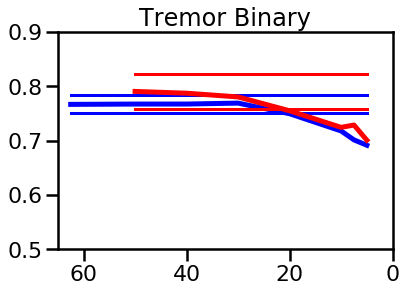

In [12]:
ax = plotFrequencies('sensor','Tremor','Binary',c='b')
plotFrequencies('watch','Tremor','Binary',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Tremor Binary')
plt.savefig('Images\\Tremor_BinaryDown.svg')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


-0.12558402720752954 0.06536257173657083
-0.10003173265148761 0.06718316031491423


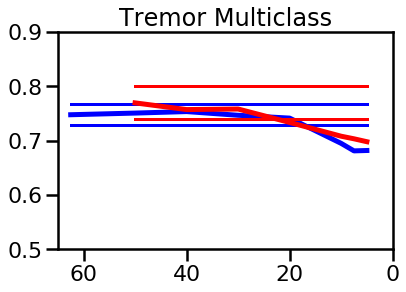

In [13]:
ax = plotFrequencies('sensor','Tremor','Multiclass',c='b')
plotFrequencies('watch','Tremor','Multiclass',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Tremor Multiclass')
plt.savefig('Images\\Tremor_MulticlassDown.svg')

-0.06035487964659112 0.050952600527058856
-0.05213393176834927 0.07593872549019626


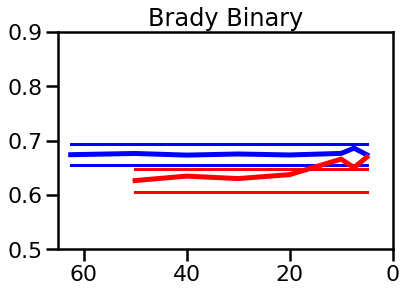

In [14]:
ax = plotFrequencies('sensor','Bradykinesia','Binary',c='b')
plotFrequencies('watch','Bradykinesia','Binary',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Brady Binary')
plt.savefig('Images\\Brady_BinaryDown.svg')

-0.042876900881105434 0.03468772092137737
-0.04233449611293494 0.042984108460531245


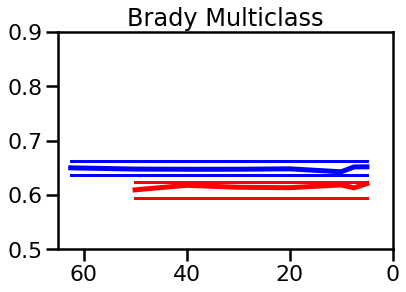

In [15]:
ax = plotFrequencies('sensor','Bradykinesia','Multiclass',c='b')
plotFrequencies('watch','Bradykinesia','Multiclass',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Brady Multiclass')
plt.savefig('Images\\Brady_MulticlassDown.svg')

In [16]:
def FreqSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = ['-', '--', (0,(3,10)), '-.', (0,(3,5,1,5)), (0,(3,10,1,10)), ':', (0, (1, 10))]
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'b']
    lw=5
    plt.figure(figsize=(12,9))
    
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
    
    done = False
    freq = max(groups)
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']

    current_auc = AUC[freq]
      
    freqInd = 0
    plotInd = 0
    ast = ''
        
    ax = plot_roc(np.vstack([d for d in data[freq]['Random Forest']['tpr'] if len(d)>0]),
                  data[freq]['Random Forest']['fpr'][0],np.nanmean(AUC[freq].values),
                  plotname=str(freq) + ' Hz',col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    for freqInd in range(1,len(groups)):
        freq = groups[freqInd]
        if freq==60 or freq==3:
            continue
            
        auc_groups = (AUC[freq].mean()-np.nanmean(current_auc))/(np.nanmean(current_auc))
        print(freq,auc_groups)
#         auc_sem = stats.sem(AUC[freq].values-current_auc, nan_policy='omit')
#         print('%.1f\t%.3f (%.3f, %.3f)'%(freq,auc_groups,auc_groups-1.98*auc_sem,auc_groups+1.98*auc_sem))
        if done:
            continue
        
#         gate = auc_groups+(CIZ*auc_sem)>0
        gate = auc_groups>-.025
        if auc_groups>0:
            current_auc = AUC[freq]
        
#         if not gate:
#             done = True
        
        plotInd+=1
        
        plot_roc(np.vstack([d for d in data[freq]['Random Forest']['tpr'] if len(d)>0]),
                 data[freq]['Random Forest']['fpr'][0],np.nanmean(AUC[freq].values),
                 plotname=str(freq) + ' Hz'+ast,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
    plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Downsampling\\' + mode + '-' + symptom + '-' + classifier + '.svg')

In [17]:
def printCIs(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
        
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
            
    for g in AUC.keys():
        auc_groups = AUC[g].mean()
        auc_sem = stats.sem(AUC[g].values, nan_policy='omit')
        print('%.1f\t%.2f (%.2f, %.2f)'%(g,auc_groups,auc_groups-1.98*auc_sem,auc_groups+1.98*auc_sem))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


50 0.0030964839053139927
40 -0.0019264390880698885
30 -0.011382307746631744
20 -0.023621129591922085
10 -0.05493875558523344
7.5 -0.06865890152602892
5 -0.08585525625454642


62.5	0.77 (0.67, 0.87)
60.0	0.77 (0.68, 0.86)
50.0	0.77 (0.67, 0.87)
40.0	0.77 (0.67, 0.87)
30.0	0.76 (0.66, 0.86)
20.0	0.75 (0.65, 0.85)
10.0	0.73 (0.64, 0.82)
7.5	0.72 (0.63, 0.81)
5.0	0.70 (0.62, 0.79)
3.0	0.57 (0.50, 0.63)


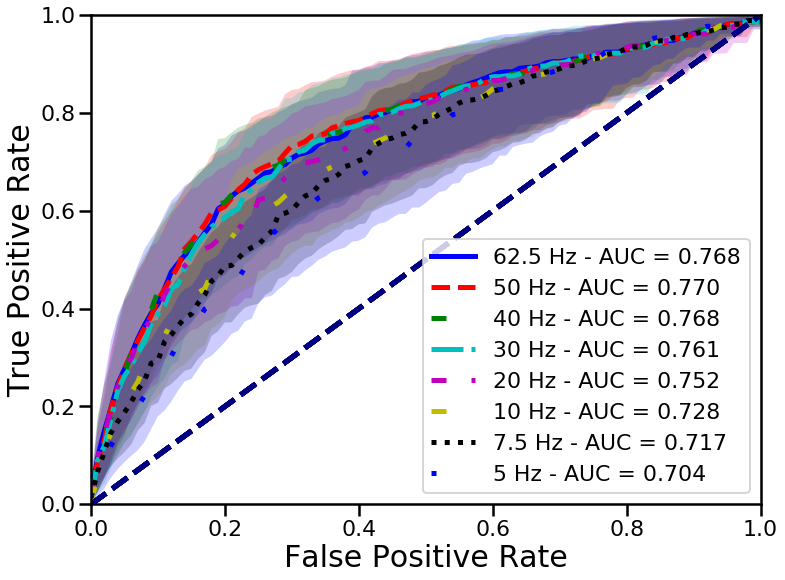

In [18]:
FreqSelection('accel','Tremor','Binary',True)
print('\n')
printCIs('accel','Tremor','Binary')

50 0.016299748877987952
40 0.0006896028611992629
30 -0.007199674334111725
20 -0.03174726068950724
10 -0.07000754200612921
7.5 -0.07590505197620481
5 -0.06882361349580723


62.5	0.74 (0.65, 0.82)
60.0	0.74 (0.66, 0.83)
50.0	0.75 (0.66, 0.84)
40.0	0.75 (0.66, 0.84)
30.0	0.74 (0.66, 0.83)
20.0	0.73 (0.64, 0.81)
10.0	0.70 (0.62, 0.78)
7.5	0.69 (0.61, 0.77)
5.0	0.70 (0.62, 0.78)
3.0	0.57 (0.52, 0.62)


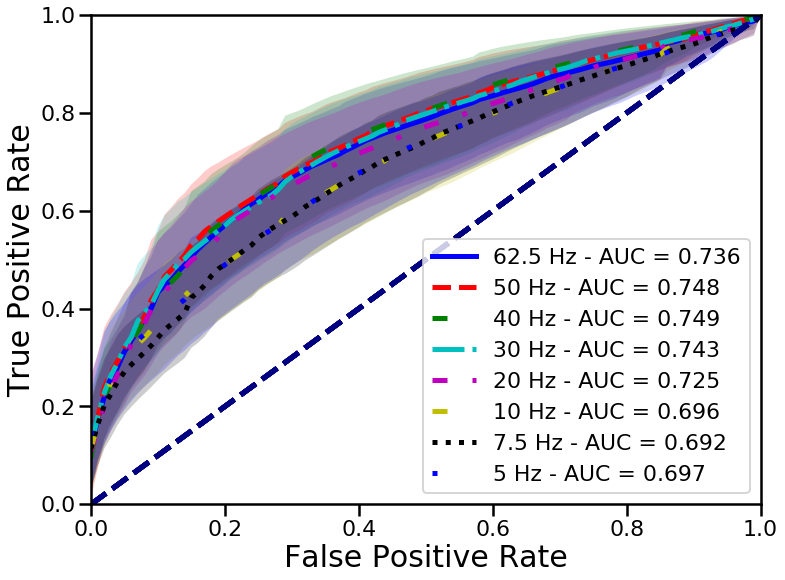

In [19]:
FreqSelection('accel','Tremor','Multiclass',True)
print('\n')
printCIs('accel','Tremor','Multiclass')

50 0.0007606968915552907
40 5.4355318302243345e-05
30 0.0022403768686783277
20 -0.025463648507990034
10 -0.06662677474275772
7.5 -0.08798624076777561
5 -0.10083031973245797


62.5	0.77 (0.68, 0.86)
60.0	0.77 (0.68, 0.86)
50.0	0.77 (0.68, 0.86)
40.0	0.77 (0.67, 0.86)
30.0	0.77 (0.68, 0.86)
20.0	0.75 (0.65, 0.85)
10.0	0.72 (0.62, 0.81)
7.5	0.70 (0.61, 0.79)
5.0	0.69 (0.60, 0.78)
3.0	0.57 (0.50, 0.63)


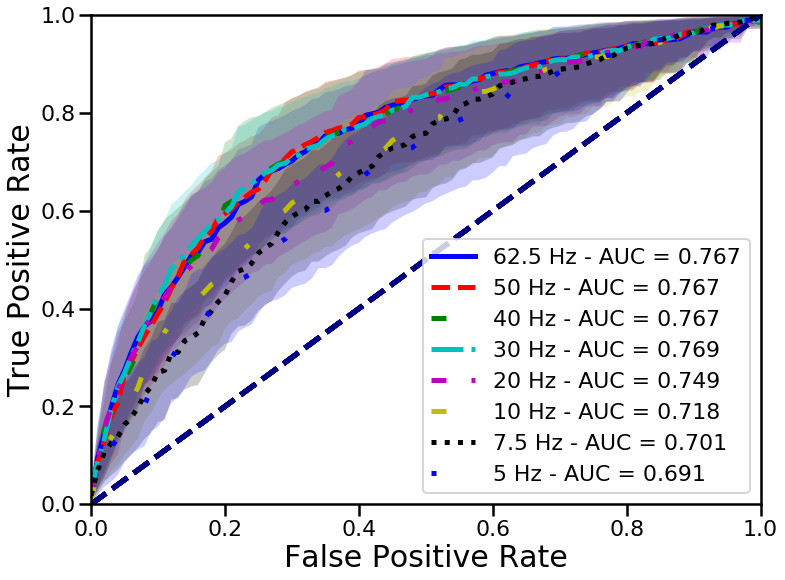

In [20]:
FreqSelection('sensor','Tremor','Binary',True)
print('\n')
printCIs('sensor','Tremor','Binary')

50 0.0040862661138017925
40 0.0036629727068289565
30 -0.00902766504879044
20 -0.015930651202852086
10 -0.07757552872479453
7.5 -0.0959552631638573
5 -0.09502772067064469


62.5	0.75 (0.67, 0.83)
60.0	0.75 (0.67, 0.83)
50.0	0.75 (0.67, 0.83)
40.0	0.75 (0.67, 0.84)
30.0	0.75 (0.66, 0.83)
20.0	0.74 (0.65, 0.83)
10.0	0.69 (0.62, 0.77)
7.5	0.68 (0.60, 0.76)
5.0	0.68 (0.60, 0.76)
3.0	0.57 (0.52, 0.62)


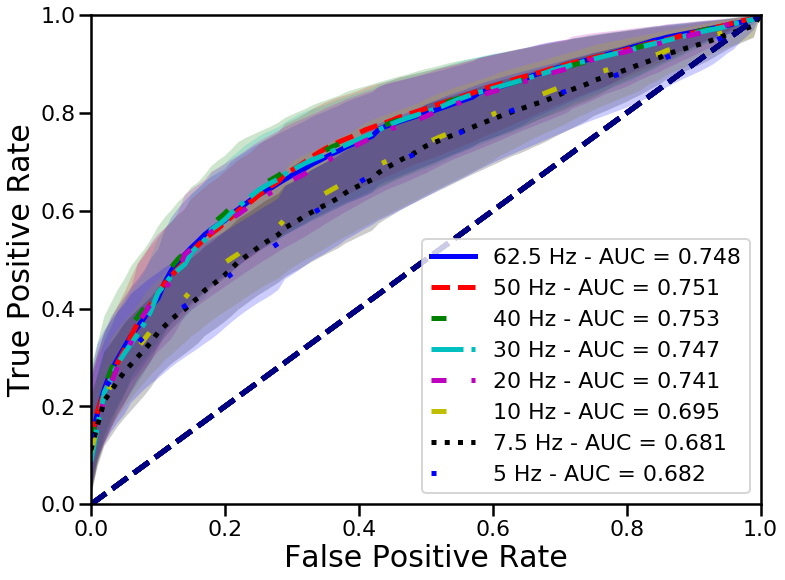

In [21]:
FreqSelection('sensor','Tremor','Multiclass',True)
print('\n')
printCIs('sensor','Tremor','Multiclass')

50 0.003301815005730905
40 -0.004441108496800771
30 -0.0013892922707703082
20 -0.004009794813616138
10 0.0001834800703926549
7.5 0.014232665817623807
5 -0.017619358074967305


62.5	0.67 (0.61, 0.74)
60.0	0.67 (0.61, 0.73)
50.0	0.68 (0.61, 0.74)
40.0	0.67 (0.61, 0.74)
30.0	0.68 (0.61, 0.74)
20.0	0.67 (0.61, 0.74)
10.0	0.68 (0.61, 0.74)
7.5	0.69 (0.62, 0.75)
5.0	0.67 (0.60, 0.74)
3.0	0.68 (0.62, 0.73)


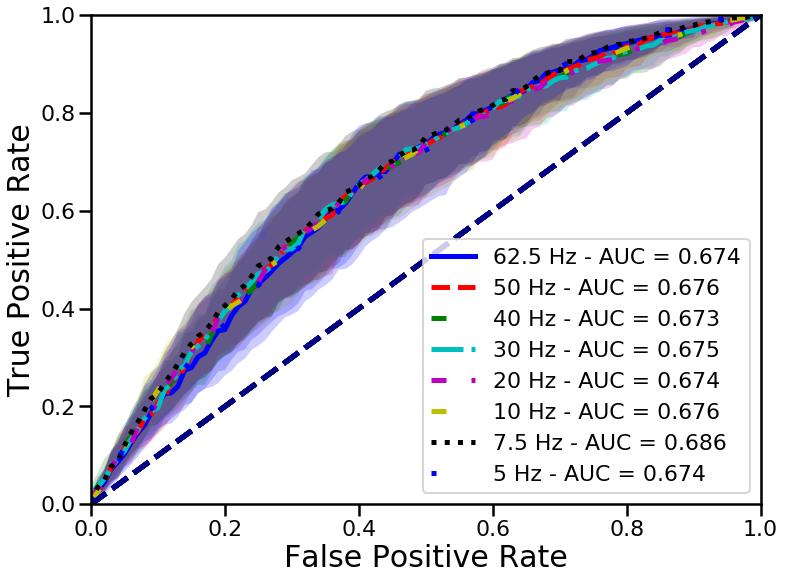

In [22]:
FreqSelection('sensor','Bradykinesia','Binary',True)
print('\n')
printCIs('sensor','Bradykinesia','Binary')

50 -0.0034140982886543434
40 -0.003968159286165235
30 -0.003900742959433766
20 -0.0027451038479475113
10 -0.011213904783896488
7.5 0.002630066081986858
5 0.0002783872926212821


62.5	0.65 (0.59, 0.71)
60.0	0.64 (0.58, 0.69)
50.0	0.65 (0.59, 0.70)
40.0	0.65 (0.59, 0.70)
30.0	0.65 (0.59, 0.70)
20.0	0.65 (0.59, 0.70)
10.0	0.64 (0.58, 0.70)
7.5	0.65 (0.60, 0.70)
5.0	0.65 (0.60, 0.71)
3.0	0.63 (0.58, 0.68)


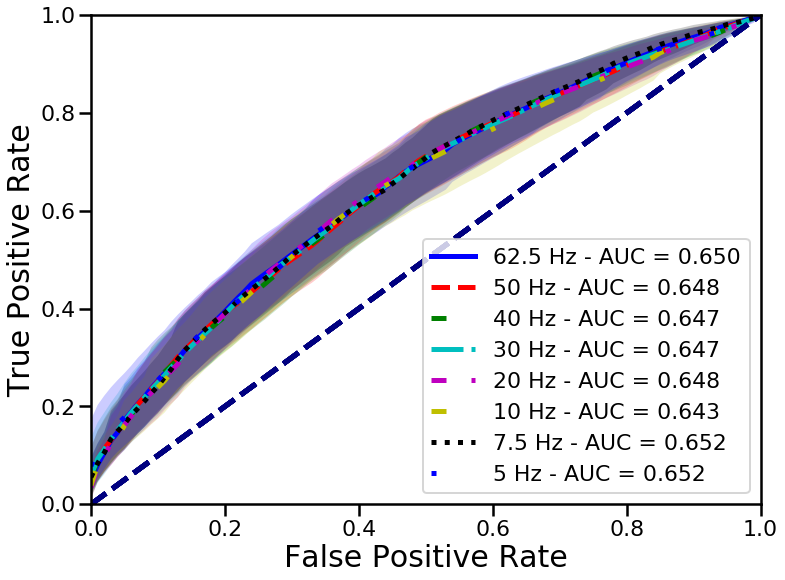

In [23]:
FreqSelection('sensor','Bradykinesia','Multiclass',True)
print('\n')
printCIs('sensor','Bradykinesia','Multiclass')

40 -0.0041269747608652305
30 -0.012844973638398993
20 -0.04504992374977199
10 -0.08363637738102882
7.5 -0.07820173917420443
5 -0.11351675071235504


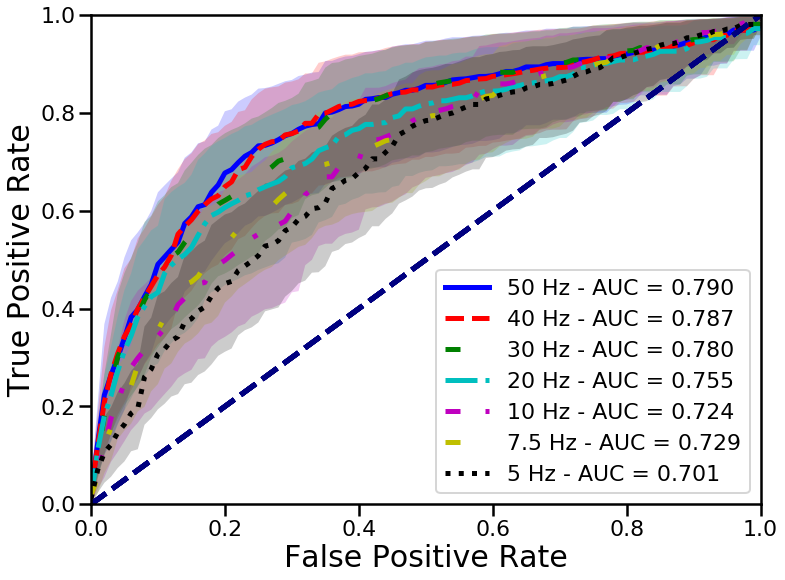

In [24]:
FreqSelection('watch','Tremor','Binary',True)

40 -0.0159934490648343
30 -0.0146610670825287
20 -0.04672789498443197
10 -0.07966908784903695
7.5 -0.08588910548979942
5 -0.09283271696535042


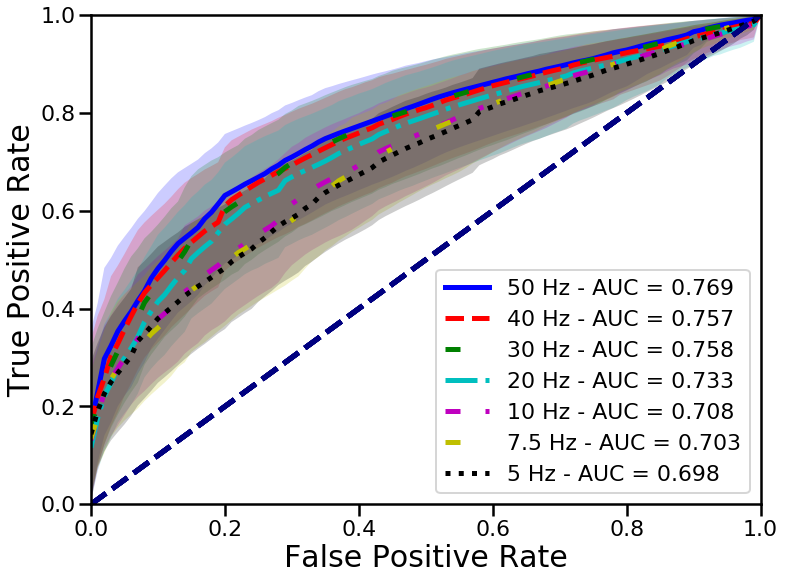

In [25]:
FreqSelection('watch','Tremor','Multiclass',True)

40 0.013085899148320998
30 -0.007151599865751126
20 0.004303867136089106
10 0.04479035303894782
7.5 -0.023465827341845026
5 0.005550099759248106


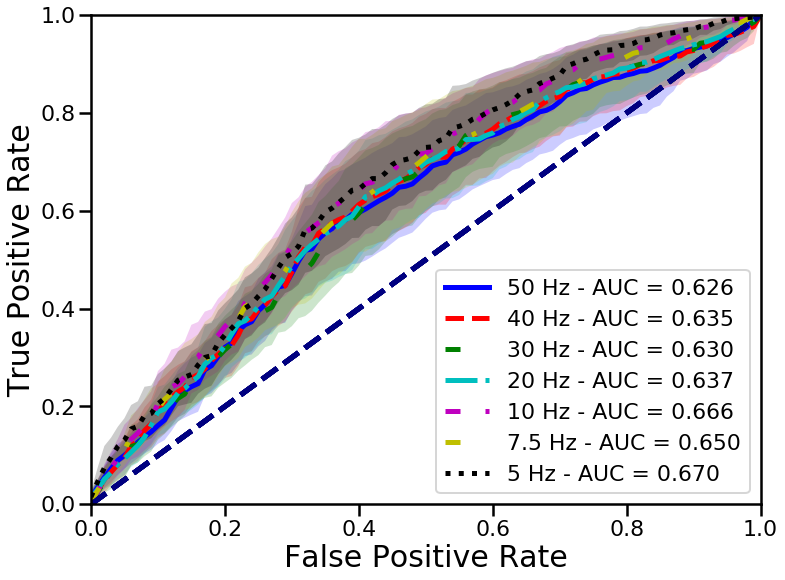

In [26]:
FreqSelection('watch','Bradykinesia','Binary',True)

40 0.013748439009817547
30 -0.005896760978079336
20 -0.007111801175683232
10 0.0010590363806085152
7.5 -0.008655112822188085
5 0.0039754194750554195


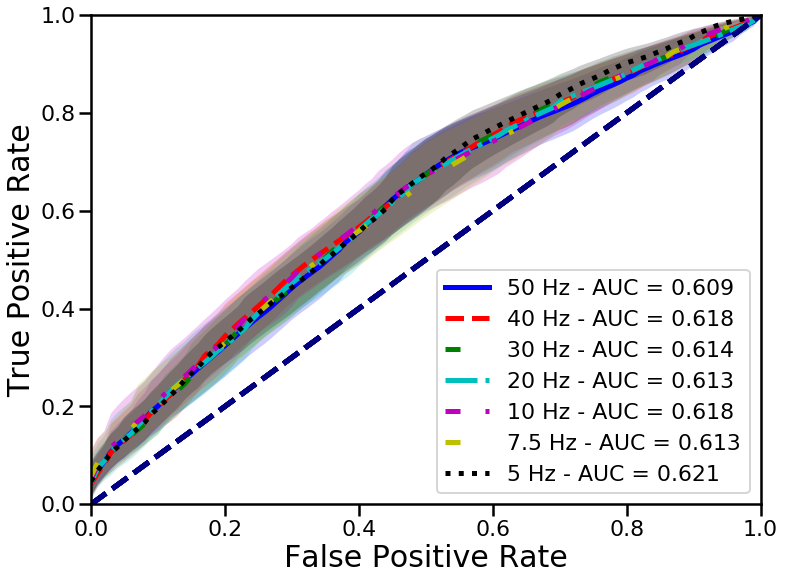

In [27]:
FreqSelection('watch','Bradykinesia','Multiclass',True)

In [28]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[col])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

def HBCorrections(df,comps,target=.05):
    res = []
    for pair in comps:
        p = PairedT(df[pair[0]].values, df[pair[1]].values)[1]
        res.append((p,str(pair[0])+'+'+str(pair[1])))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<thresh and dec=='Reject':
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s%.3f\t%.3f\t%s'%(r[1]+' '*(13-len(r[1])),r[0],thresh,dec))

In [29]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(42.31886915119189, 4.547215759735945e-30)

In [30]:
HBCorrections(D,[(62.5,50),(62.5,40),(62.5,30),(62.5,20),(62.5,10),(62.5,7.5),(62.5,5)])


62.5+10      0.000	0.007	Reject
62.5+5       0.000	0.008	Reject
62.5+7.5     0.000	0.010	Reject
62.5+20      0.011	0.013	Reject
62.5+30      0.691	0.017	Accept
62.5+50      0.817	0.025	Accept
62.5+40      0.917	0.050	Accept


In [31]:
D = pd.DataFrame(data = np.vstack([MultiResults['sensor']['Tremor'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(25.895796692264103, 2.4609409360466916e-22)

In [32]:
HBCorrections(D,[(62.5,50),(62.5,40),(62.5,30),(62.5,20),(62.5,10),(62.5,7.5),(62.5,5)])

62.5+7.5     0.000	0.007	Reject
62.5+10      0.000	0.008	Reject
62.5+5       0.003	0.010	Reject
62.5+20      0.333	0.013	Accept
62.5+40      0.449	0.017	Accept
62.5+50      0.662	0.025	Accept
62.5+30      0.818	0.050	Accept


In [33]:
HBCorrections(D,[(62.5,50),(50,40),(50,30),(50,20),(50,10),(50,7.5),(50,5)])

50+7.5       0.001	0.007	Reject
50+5         0.001	0.008	Reject
50+10        0.002	0.010	Reject
50+20        0.229	0.013	Accept
50+30        0.451	0.017	Accept
50+40        0.560	0.025	Accept
62.5+50      0.662	0.050	Accept


In [34]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.12420095141283037, 0.9990145504135509)

In [35]:
D = pd.DataFrame(data = np.vstack([MultiResults['sensor']['Bradykinesia'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.959522298819922, 0.4775750335490965)

In [36]:
D = pd.DataFrame(data = np.vstack([results['watch']['Tremor']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(5.332242856406569, 5.289431420758845e-05)

In [37]:
HBCorrections(D,[(50,40),(50,30),(50,20),(50,10),(50,7.5),(50,5)])

50+7.5       0.000	0.008	Reject
50+5         0.001	0.010	Reject
50+10        0.006	0.013	Reject
50+20        0.166	0.017	Accept
50+30        0.239	0.025	Accept
50+40        0.411	0.050	Accept


In [38]:
D = pd.DataFrame(data = np.vstack([MultiResults['watch']['Tremor'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(5.098574892034956, 8.58993141631479e-05)

In [39]:
HBCorrections(D,[(50,40),(50,30),(50,20),(50,10),(50,7.5),(50,5)])

50+5         0.000	0.008	Reject
50+7.5       0.000	0.010	Reject
50+10        0.003	0.013	Reject
50+30        0.014	0.017	Reject
50+20        0.158	0.025	Accept
50+40        0.219	0.050	Accept


In [40]:
D = pd.DataFrame(data = np.vstack([results['watch']['Bradykinesia']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(2.4518014565827038, 0.0244827146959752)

In [41]:
HBCorrections(D,[(50,40),(50,30),(50,20),(50,10),(50,7.5),(50,5)])

50+5         0.041	0.008	Accept
50+10        0.053	0.010	Accept
50+40        0.142	0.013	Accept
50+7.5       0.143	0.017	Accept
50+20        0.285	0.025	Accept
50+30        0.623	0.050	Accept


In [42]:
D = pd.DataFrame(data = np.vstack([MultiResults['watch']['Bradykinesia'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.19059992300888695, 0.9866859254765642)